## Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.       
       
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.       
      
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

#### Загрузка данных и библиотек

In [84]:
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import levene

import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns

from sklearn.linear_model import LinearRegression

from math import isnan 

init_notebook_mode(connected=True)

In [2]:
games = pd.read_csv('games.csv')

#### Подготовка данных

In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
games.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

- пропусков в названиях и жанрах очень мало - заменим из на пустые строки,  
- нужно проверить, возможно ли заполнить пропуски оценок пользователей и критиков на основе имеющихся данных,
- остальные пропуски можно оставить незаполненными, 
- год выпуска задан типом float - нужно заменить на целочисленные значения,
- нет колонки общих продаж - можно создать ее, просуммировав все продажи  

##### Обработка пропусков и типов данных

Оценка пользователя 'tbd' (to be determeined) означает, что он еще не решил, какую оценку фильму поставить. Для того чтобы проверить корреляцию оценок пользователей и оценки критиков, удалим данные значения. Пропущенные значения в названиях и жанрах заполним пустыми строками.

In [6]:
games['User_Score'] = games['User_Score'].replace("tbd", np.NaN)

In [7]:
games.isna().sum().sum()

24742

In [8]:
for i in [0, 1, 3]:
    games.iloc[:, i] = games.iloc[:, i].str.lower()

In [9]:
games.fillna({
    'Name': '',
    'Genre': '',
}, inplace=True)

In [10]:
games['User_Score'] = games['User_Score'].astype(float)
games['Critic_Score'] = games['Critic_Score'].astype(float)

In [11]:
games['Overall_sales'] = games['NA_sales'] + games['EU_sales'] + games['JP_sales'] + games['Other_sales']

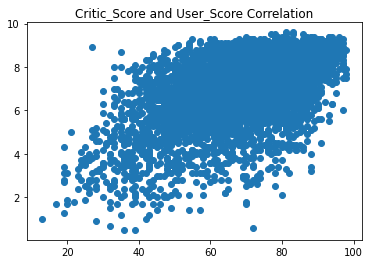

Correlation coeff: 0.5808778320767243


In [12]:
corr_data = games[['Critic_Score', 'User_Score']].dropna()

plt.scatter(corr_data.Critic_Score, corr_data.User_Score)
plt.title('Critic_Score and User_Score Correlation')
plt.show()

print('Correlation coeff:', corr_data.Critic_Score.corr(corr_data.User_Score))

Между признаками Critic_Score и User_Score достаточно слабая линейная зависимость, поэтому, заполняя пропуски линейной регрессией, можно испортить статистику. Проверим, имеют ли отдельные жанры и платформы более сильную связь по оценкам критиков и пользователей.

In [13]:
corr_data = games[['Critic_Score', 'User_Score', 'Platform', 'Genre']].dropna()

In [14]:
platforms = corr_data.groupby('Platform').count().index
corr_platforms = []
for i in range(platforms.shape[0]):
    c = corr_data[corr_data['Platform'] == platforms[i]].Critic_Score.corr(corr_data[corr_data['Platform'] == platforms[i]].User_Score)
    if c > 0.65:
        corr_platforms.append(platforms[i])
        print('Correlation for', platforms[i], ':', round(c, 2))

Correlation for 3ds : 0.74
Correlation for ds : 0.66
Correlation for ps : 0.69
Correlation for psv : 0.73
Correlation for wii : 0.68
Correlation for wiiu : 0.77


In [15]:
genres = corr_data.groupby('Genre').count().index
corr_genres = []
for i in range(genres.shape[0]):
    c = corr_data[corr_data['Genre'] == genres[i]].Critic_Score.corr(corr_data[corr_data['Genre'] == genres[i]].User_Score)
    if c > 0.65:
        corr_genres.append(genres[i])
        print('Correlation for', genres[i], ':', round(c, 2))

Correlation for adventure : 0.72
Correlation for platform : 0.67
Correlation for puzzle : 0.74


In [16]:
data = games[(games['Genre'].isin(corr_genres)) | (games['Platform'].isin(corr_platforms))]

In [17]:
train_features = data[(data['Critic_Score'].isna() == False) & (data['User_Score'].isna() == False)][['User_Score']]
train_target = data[(data['Critic_Score'].isna() == False) & (data['User_Score'].isna() == False)][['Critic_Score']]

test = data[(data['Critic_Score'].isna() == True) & (data['User_Score'].isna() == False)][['User_Score']]

indecies = test.index
test.reset_index(drop=True, inplace=True)

In [18]:
model = LinearRegression().fit(train_features, train_target)
preds = pd.DataFrame(model.predict(test))

In [19]:
scores = pd.concat([preds, test], axis=1)
scores.columns = ['Critic_score', 'User_score']
scores.index = indecies

In [20]:
for i in games.index:
    if i in scores.index:
        games.iloc[i, -4] = scores[scores.index == i].iloc[0, 0]

In [21]:
#Аналогично заполним пропуски для User_Score:
train_features = data[(data['Critic_Score'].isna() == False) & (data['User_Score'].isna() == False)][['Critic_Score']]
train_target = data[(data['Critic_Score'].isna() == False) & (data['User_Score'].isna() == False)][['User_Score']]

test = data[(data['Critic_Score'].isna() == False) & (data['User_Score'].isna() == True)][['Critic_Score']]

indecies = test.index
test.reset_index(drop=True, inplace=True)

model = LinearRegression().fit(train_features, train_target)
preds = pd.DataFrame(model.predict(test))

scores = pd.concat([preds, test], axis=1)
scores.columns = ['User_score', 'Critic_score']
scores.index = indecies

for i in games.index:
    if i in scores.index:
        games.iloc[i, -3] = scores[scores.index == i].iloc[0, 0]

In [22]:
games.isna().sum().sum()

24006

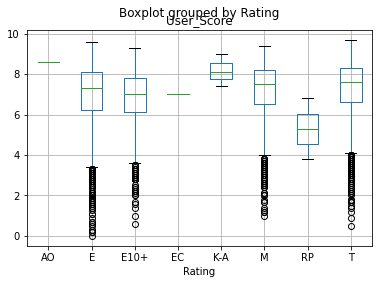

In [23]:
games.boxplot(column='User_Score', by='Rating')

plt.show()

Разброс оценок для соответсующего рейтинга слишком большой, поэтому заполнение пропущенных оценок пользователей по рейтингу и наоборот будет некорректным.

> С помощью заполнения названий и жанров пустыми строками, а также восстановления оценок критиков и пользователей с помощью линейной регрессии удалось заполнить более 700 пропусков.

## Исследовательский анализ данных

#### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [24]:
df = pd.DataFrame(games.groupby('Year_of_Release')['Name'].count())
fig = px.line(df, x=df.index, y="Name", title='Число игр по годам')

iplot(fig, show_link = False)

> Можно заметить, что пик популярности видеоигр пришелся на 2008-2009 гг (1427), а затем резко стал падать и снизился более чем в два раза, дойдя до уровня 2001 года (606). Данные до 1993 года неважны, так как в период с 1980 по 1993 год продажи были стабильно низкими (менее 60).

#### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [25]:
games = games[games['Year_of_Release'] >= 1994] 

In [26]:
df = pd.DataFrame(games.groupby(['Platform', 'Year_of_Release'])['Overall_sales'].sum())
df.reset_index(inplace=True)

In [27]:
top15 = pd.DataFrame(df.groupby('Platform')['Overall_sales'].sum().sort_values(ascending=False)[:15])
top5 = top15[:5]

In [28]:
fig = px.bar(top15, top15.index, y='Overall_sales', color='Overall_sales')

iplot(fig, show_link = False)

Из графика видно, что самые популярные игровые платформы за весь период это PS2, X360, PS3, WII, DS, PS. Проанализируем их продажи по годам:

In [29]:
df = df[(df['Platform'].isin(top5.index))]

fig = go.Figure()


for p in top5.index:
    fig.add_trace(go.Bar(
        x=df[df['Platform'] == p]['Year_of_Release'],
        y=df[df['Platform'] == p]['Overall_sales'],
        name=p
    ))

fig.update_layout(title='Продажи игровых платформ с 2000 по 2016 года')

iplot(fig, show_link = False)

In [30]:
#жизненный цикл платформы в годах:
df.groupby('Platform')['Year_of_Release'].max() - df.groupby('Platform')['Year_of_Release'].min()

Platform
ds       9.0
ps2     11.0
ps3     10.0
wii     10.0
x360    11.0
Name: Year_of_Release, dtype: float64

Из графиков видно, что 
- каждая платформа развивалась постепенно и имела пик примерно в середине жизненного цикла (на пятый год);
- в среднем платформа существует на рынке около 10 лет; 
- самые продаваемые платформы: Sony Play Station и XBOX;

#### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. 
#### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Из графика "Продажи игровых платформ с 2000 по 2016 года" видно, что впервые 4 из 5 популярных игровых платформ появились в 2006 году, поэтому определим эту границу как начало актуального периода.

In [31]:
games = games[games['Year_of_Release'] >= 2006]
games.reset_index(inplace=True, drop=True)

In [32]:
grouped_games = games.groupby(['Platform', 'Year_of_Release'])['Overall_sales'].sum()
grouped_games = pd.DataFrame(grouped_games).reset_index()
grouped_games['Growth'] = 0

In [33]:
for p in grouped_games.Platform.unique():
    g = grouped_games[grouped_games['Platform'] == p]
    for i in range(g.shape[0]-1):
        grouped_games.iloc[g.index[i+1],-1] = g.iloc[i+1, -2]/g.iloc[i, -2]

In [34]:
grouped_games

,Platform,Year_of_Release,Overall_sales,Growth
0,3ds,2011.0,63.20,0.000000
1,3ds,2012.0,51.36,0.812658
2,3ds,2013.0,56.57,1.101441
3,3ds,2014.0,43.76,0.773555
4,3ds,2015.0,27.78,0.634826
...,...,...,...,...
97,xb,2008.0,0.18,0.327273
98,xone,2013.0,18.96,0.000000
99,xone,2014.0,54.07,2.851793
100,xone,2015.0,60.14,1.112262


Чтобы найти потенциальные для развития платформы, оставим в данных только те, которые существовали в 2016 году:

In [35]:
g = pd.DataFrame(grouped_games.groupby('Platform')['Year_of_Release'].max())
g = g[g.Year_of_Release == 2016]

In [36]:
games_growth = grouped_games[grouped_games['Platform'].isin(g.index)]

In [37]:
games_growth

,Platform,Year_of_Release,Overall_sales,Growth
0,3ds,2011.0,63.20,0.000000
1,3ds,2012.0,51.36,0.812658
2,3ds,2013.0,56.57,1.101441
3,3ds,2014.0,43.76,0.773555
4,3ds,2015.0,27.78,0.634826
...,...,...,...,...
94,x360,2016.0,1.52,0.127090
98,xone,2013.0,18.96,0.000000
99,xone,2014.0,54.07,2.851793
100,xone,2015.0,60.14,1.112262


In [38]:
fig = px.line(games_growth, x="Year_of_Release", y="Growth", color='Platform', 
              title='Рост продаж игровых платформ с 2006 по 2016 год')

iplot(fig, show_link = False)

Ни у одной из платформ не наблюдается рост в 2016 году, меньше всего из них продажи упали у платформ: PlayStation Vita, PC, PlayStation 4, однако, у последней наблюдается резкий спад с 2014 года.

#### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

In [114]:
fig = px.box(games, x="Platform", y="Overall_sales", title = 'Продажи по платформам')

iplot(fig, show_link = False)

У многих платформ есть множество выбросов, то есть игр, наиболее понравившихся пользователям. Чтобы посмотреть на продаже детальнее, ограничим значения выбросов до 2:

In [40]:
sales = games[games.Overall_sales < 2]
fig = px.box(sales, x="Platform", y="Overall_sales", title = 'Продажи по платформам')
fig.show()
iplot(fig, show_link = False)

- Исходя из графиков видно, что медианы продаж отличаются. Это может готоворить как о небольшой популярности игр платформы, так и невысоких ценах.
- Больше всех продаж у PS3, которая также выпускала игры, выручка которых превышала медианную более, чем в 80 раз. Затем X360, после PS2, WII и DS на последнем месте в топ-5 платформ. 

#### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Одной из самых популярных и актуальных платформ является PS3, изучим влияние отзывов на число продаж для нее:

Диаграмма рассеяния для PS3
Коэффициент корреляции для User_Score и Overall_sales: 0.23
Коэффициент корреляции для Critic_Score и Overall_sales: 0.08


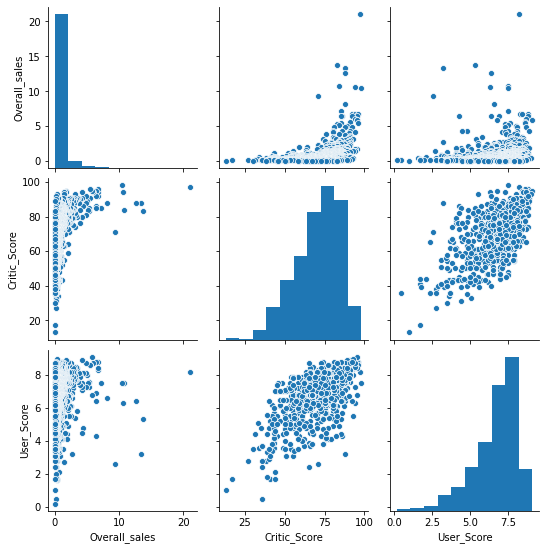

In [41]:
print("Диаграмма рассеяния для PS3")
sns.pairplot(games[games.Platform == "ps3"][['Overall_sales', 'Critic_Score', 'User_Score']])

print("Коэффициент корреляции для User_Score и Overall_sales:", round(games['Overall_sales'].corr(games['Critic_Score']),2))
print("Коэффициент корреляции для Critic_Score и Overall_sales:", round(games['Overall_sales'].corr(games['User_Score']),2))
plt.show()

Корреляции между оценками критиков и продажами нет, зависимость продаж от рейтинга среди позльзователей выше, однако все же является довольно слабой - 0.23.

#### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [42]:
x=pd.DataFrame(games['Genre'].value_counts())
x.reset_index(inplace=True)
genres = x.iloc[:5, 0]

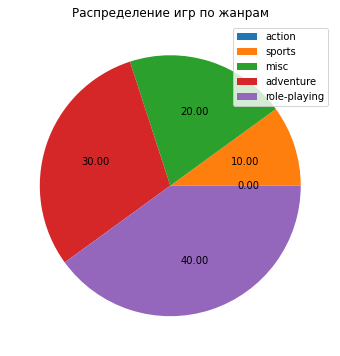

In [46]:
plt.figure(figsize=(18,6))

plt.pie(x=x.index[:5], autopct="%.2f")
plt.title('Распределение игр по жанрам')
plt.legend(genres)
plt.show()

In [47]:
games.groupby('Genre')[['Overall_sales']].sum().sort_values('Overall_sales', ascending=False).style.bar()

,Overall_sales
Genre,
action,1116.650000
sports,793.850000
shooter,717.040000
misc,554.860000
role-playing,522.400000
racing,299.000000
platform,279.740000
simulation,220.650000
fighting,188.420000


Вывод по исследовательскому анализу данных:

- Количество игр начало расти с большой скоростью с 90х годов до 2008 года. С 2008 года, после того как массово начали создавать мобильные приложения и мобильные игры, произошел резкий спад разработок игр на игровые платформы.
- Самые популярные игровые платформы за весь период : Sony PlayStation 2, Xbox 360, Sony Playstation 3, Nintendo WII, Nintendo DS, Sony Playstation.
- В среднем игроая платформа существует на рынке 10 лет. Пик продаж наступает примерно через 5 лет после создания платформы.
- Больше всего продаются игры на Sony Playstation и Xbox 360
- Nintendo WII как быстро появился также быстро и потух. Возможно потому что время создания платформы сопало с ростом популярности мобильных приложений и игр.
- Наблюдается взаимосвязь между продажами и оценками пользователей.

### Портрет пользователя каждого региона

В наборе данных присутствует информация о продажах игр в нескольких регионах: NA (Северная Америка), EU(Европа) и JP(Япония). Для каждого из регионов определим самые популярные платформы, жанры и влияние рейтинга ESRB на продажи.

In [48]:
traces = []
for region in ["NA_sales", "EU_sales", "JP_sales"]:
    for_plot = pd.DataFrame(games.groupby('Genre')[region].sum().sort_values(ascending=False)[:5]).reset_index()
    traces.append(
            go.Bar(
                x=for_plot['Genre'], 
                y=for_plot[region],
                name = i, 
                visible = (region == 'NA_sales')))

    
layout = go.Layout(
    title="Продажи по жанрам",
    updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True] + [False]*3],
                    label='NA',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False] + [True] + [False]*2],
                    label='EU',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False]*2 + [True] + [False]],
                    label='JP',
                    method='restyle'
                )
            ]),
        )
    ]),
)

fig = {'data': traces, 'layout': layout}
iplot(fig, show_link=False)

In [49]:
def analyze(region, title):
    fig, axes = plt.subplots(1, 2, figsize=(20, 4))
    for i, ax in zip(('Platform', 'Rating'), axes.flatten()[:3]):
        for_plot = pd.DataFrame(games.groupby(i)[region].sum().sort_values(ascending=False)[:5]).reset_index()
        sns.barplot(data=for_plot, x=for_plot[i], y=for_plot[region], ax=ax)
        fig.suptitle('Топ 5 жанров и рейтингов за весь период в {}'.format(title), fontsize=15)

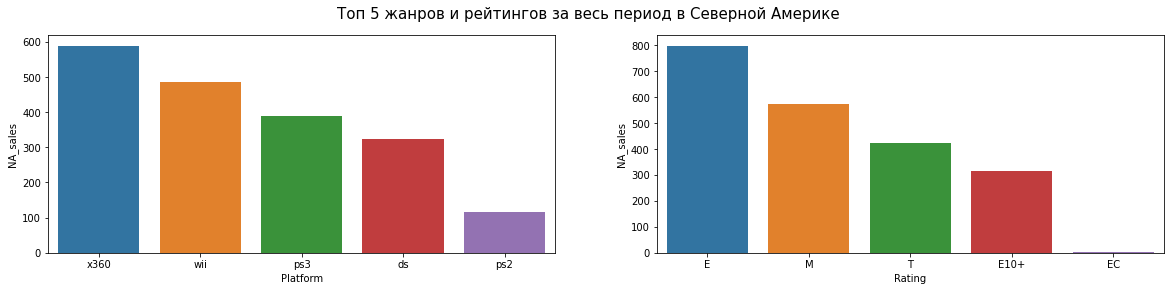

In [50]:
analyze('NA_sales', 'Северной Америке')

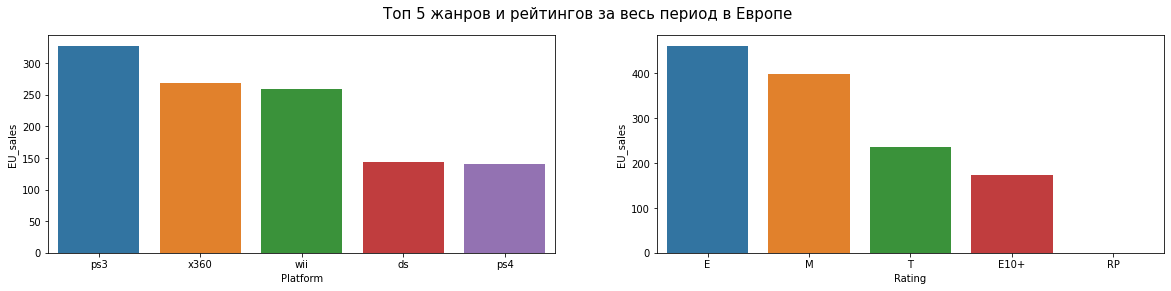

In [51]:
analyze('EU_sales', 'Европе')

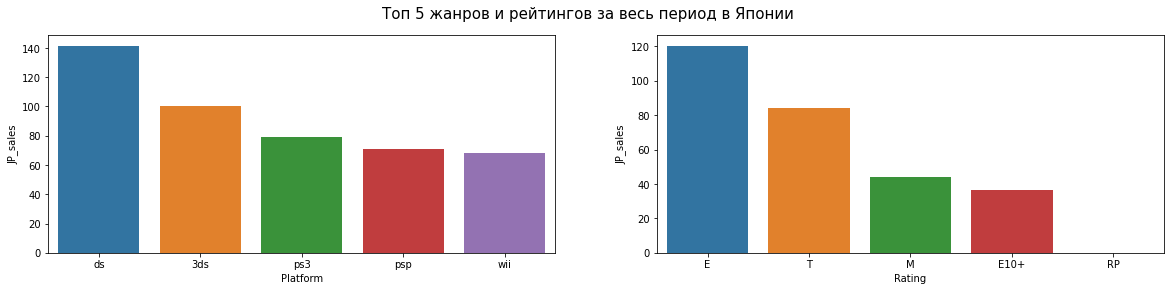

In [52]:
analyze('JP_sales', 'Японии')

Расшифровка обозначений:

- «EC» («Early childhood») — «Для детей младшего возраста»
- «E» («Everyone») — «Для всех»  
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»  
- «M» («Mature») — «Для взрослых»  
- «RP» («Rating Pending») — «Рейтинг ожидается»

- Пользователи Северной Америки и Европы схожи в предпочтениях по жанрам: в обоих случаях первые три места занимают жанры Action, Sports и Shooter. Вкусы японских пользователей же отличаются - явным лидером у них является жанр Role-Playing, за которым идет самый популярный в остальных регионах Action, а жанр Shooter вообще отствутвует в топ 5.
- Во всех регионах предпочтений по платформам сильно отличаются. Так, в Японии по данным за 2006-2016 года самой популярной плтаформой была DS, в Европе - PS2 и в Северной Америке X360.
- Самыми популярными категориями являются игры "для всех", затем "подросткам" (в Японии и Северной Америке) и "взрослым" в Европе.

#### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [75]:
traces = []
for region in ["NA_sales", "EU_sales", "JP_sales"]:
    traces.append(
            go.Box(
                x=games['Rating'], 
                y=games[region],
                visible = (region == 'NA_sales')))

    
layout = go.Layout(
    title="Продажи по жанрам", yaxis=dict(range=[0,1]),
    updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True] + [False]*3],
                    label='NA',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False] + [True] + [False]*2],
                    label='EU',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False]*2 + [True] + [False]],
                    label='JP',
                    method='restyle'
                )
            ]),
        )
    ])
)


fig = {'data': traces, 'layout': layout}

iplot(fig, show_link=False)

- Во всех регионах лидируют игры с рейтингом M - "Для взрослых".                 
- В Северной Америке также большую часть рынка занимают игры для маленьких детей.          
- В Японии очень много игр для взрослых и подростков, а остальные типы крайне не популярны.

### Проверка гипотез

##### 1 гипотеза
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. 
- Ho - средние оценки пользователей платформ XBox One и PC равны;
- H1 - средние оценки отличаются.

In [96]:
sample_1 = games[games['Platform']=="xone"]['User_Score'].dropna() 
sample_2 = games[games['Platform']=="pc"]['User_Score'].dropna()

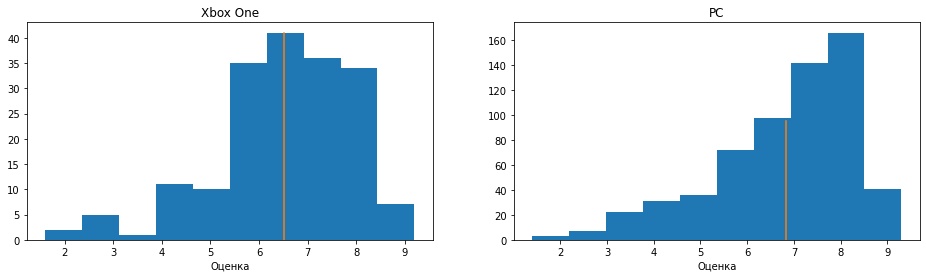

               Дисперсия Xbox One - 1.91;                                           Дисперсия PC - 2.30;

Дисперсии отличаются на: 20.85%


In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.hist(sample_1)
ax1.plot([sample_1.mean(), sample_1.mean()], [0, 40])
ax1.set_title("Xbox One")
ax1.set_xlabel("Оценка")

ax2.hist(sample_2)
ax2.plot([sample_2.mean(), sample_2.mean()], [0, 100])
ax2.set_title("PC")
ax2.set_xlabel("Оценка")

plt.show() 
print("               Дисперсия Xbox One - {:.2f};                                           Дисперсия PC - {:.2f};\n\nДисперсии отличаются на: {:.2%}"
      .format(sample_1.var(),  sample_2.var(), sample_2.var()/sample_1.var() -1))

Для начала проверим, отличаются ли статистически дисперсии выборок. Для этого будет использован тест Левена, при котором нулевая гипотеза соответствует утверждению о равенстве дисперсий и альтернативная об обратном:

In [98]:
stat, p = levene(sample_1, sample_2)
print('Значение p-value:', round(p, 3))

Значение p-value: 0.2144


Резуьтат теста Левена показал, что дисперсии оценок двух платформ можно считать одинаковыми. Следовательно при проведении статистического теста (двусторонний T-тест) следует использовать параметр equal_var = True.

In [88]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем нулевую гипотезу

results_1 = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var = True)

print('p-значение:', results_1.pvalue)

# if (results.pvalue < alpha): # твой код
if (results_1.pvalue < alpha): # код ревьюера
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.014334467652842166
Отвергаем нулевую гипотезу


> Проеведенный тест показал, что средние оценки пользователей платформ Xbox One и PC отличаются, так как p-value меньше порогового значения, и, соответственно, нет оснований не отвергать нулевую гипотезу.

##### 2 гипотеза. 
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. 

- Ho - средние пользователбские рейтинги жанров Action и Sports равны;
- H1 - средние оценки отличаются.

In [101]:
sample_1 = games[games['Genre']=="action"]['User_Score'].dropna() 
sample_2 = games[games['Genre']=="sports"]['User_Score'].dropna()

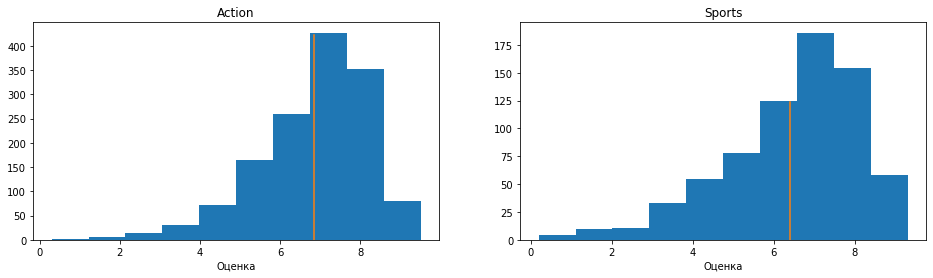

               Дисперсия Action - 1.80;                                           Дисперсия Sports - 2.63;

Дисперсии отличаются на: 46.23%


In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.hist(sample_1)
ax1.plot([sample_1.mean(), sample_1.mean()], [0, 423])
ax1.set_title("Action")
ax1.set_xlabel("Оценка")

ax2.hist(sample_2)
ax2.plot([sample_2.mean(), sample_2.mean()], [0, 124])
ax2.set_title("Sports")
ax2.set_xlabel("Оценка")

plt.show() 
print("               Дисперсия Action - {:.2f};                                           Дисперсия Sports - {:.2f};\n\nДисперсии отличаются на: {:.2%}"
      .format(sample_1.var(),  sample_2.var(), sample_2.var()/sample_1.var() -1))

In [109]:
stat, p = levene(sample_1, sample_2)
print('Значение p-value:', p)

Значение p-value: 2.030280841397305e-06


Значение p-value по тесту Левена критически мало, что дает основания считать дисперсии выборок отличающимися.

In [113]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results_2 = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var = False)

print('p-value:', results_2.pvalue)

if (results_2.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 8.827191983139881e-10
Отвергаем нулевую гипотезу


Предположение о разных средних оценках для жанров Action и Sports подтвердилось, так как значение p-value ниже уровня статистической значимости и позволяеть отклонить нулевую гипотезу.

### Общий вывод

#### Знакомство с данными
- Ознакомились с данными, посмотрели на общую информацию о датасете, выявили пропуски и не соответствие типов данных.  
#### Подготовка данных    
- На данном шаге мы заполнили некоторые пропуски, обнаружили необычное значение tbd - "to be determined" и заменили это значение на NaN.      
- Многие пропуски, например в столбцах оценок мы оставили незаполненными, чтобы не исказить статистику.      
- Также на данном этапе мы посчитали общее количество продаж по всем регионам и записали результат в столбец total_sales.  
#### Исследовательский анализ данных     
- Было обнаружено, что резкий рост выпуска игр приходится на 2000 год, а пик на 2008-2009 гг.   
- Характерный срок жизни платформы - 10 лет, поэтому были оставлены данные с 2006 по 2016 гг.     
- 3 потенциально прибыльных платформы -  PlayStation Vita, PC, PlayStation 4,.     
- Наибольшие медианные продажи у платформ X360 и PS3.   
- Почти у всех платформ есть определенные игры, которые "выстрелили".    
- Компьютерные игры PC стоят дешевле консольных.      
- Оценки критиков очень слабо влияют на общие продажи, оценки пользователей не влияют совсем.   
- Больше всего игр жанра Action, затем идут Sports, misc и adventure.     
- Лучше всего покупают игры жанра Action, Sports идёт на втором месте, Shooter неожиданно стоит на третьем месте по продажам.  
- Adventure сильно отстаёт по продажам, хотя игр выпускается много.  
#### Портрет пользователя региона      
- В Северной Америке самая популярная платформа X360. Европейцы предпочитают PS3. В Японии популярны DS.     
- В Северной Америке и Европе самые популярные жанры практически совпадают - там популярны Action и Sports. В JP предпочтения пользователей сильно отличаются - самый востребованный жанр Role-Playing.     
- Во всех регионах лидируют игры с рейтингом M - "Для взрослых". В Северной Америке большую часть рынка занимают игры для маленьких детей. В Японии очень много игр с рейтингом M и T, а остальные крайне не популярны. 
#### Проверка гипотез    
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Гипотеза не подтвердилась.       
- Средние пользовательские рейтинги жанров Action и Sports разные. Гипотеза подтвердилась!.